In [1]:
import os
import pickle
import numpy as np
from bayes_opt import BayesianOptimization
from utils.TSDataset import data_load
from utils.cnnlstm_eval import cnn_lstm_model_eval
from utils.models import *
from utils.model_bo import cnn_lstm_model_bo

In [2]:
project_dir = os.path.dirname(os.path.abspath('__file__'))

if not os.path.exists(os.path.join(project_dir, 'output')):
    os.makedirs(os.path.join(project_dir, 'output'))

data_path = os.path.join(project_dir, 'data', 'processed', 'BTC-USD-sample.csv')

# Load data
data, x_scaler, y_scaler = data_load(data_path, x_scaler='minmax', y_scaler='minmax')

# Configuration
data_frame       = data
scaler           = y_scaler
feature_cols     = ['x1','x2','x3','x4','x5']
target_col       = 'y'
seq2seq          = True

strides          = 1

full = data[feature_cols + [target_col]].to_numpy(dtype=np.float32)
np.save('full.npy', full)

npy_path        = 'full.npy'
targ_idx = 0
feat_idx = list(range(1,6))

In [3]:
# One Step Forecasting
forecast_horizon = 1

# Step 1: Define hyperparameter bounds
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (1, 2),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# Step 2: Define the target function
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_bo(
        df=data_frame, npy_path=npy_path, verbose=True,
        feat_idx = feat_idx,
        targ_idx = targ_idx,
        dates_npy_path = None,
        filters=int(filters),
        kernel_size=int(kernel_size),
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        forecast_horizon=forecast_horizon
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=1, n_iter = 0)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------


Epoch 01 | val_loss: 0.0000 | val_time:  40.01s
| 1         | -3.714e-0 | 57.95     | 1.951     | 191.7     | 5.592     | 0.01561   | 53.44     | 221.3     |
🔍 Best hyperparameters: {'batch_size': 57, 'epochs': 1, 'filters': 191, 'kernel_size': 5, 'learning_rate': 0, 'lstm_units': 53, 'window_size': 221}


In [3]:
forecast_horizon = 1
# Example best

best = {'filters': 16, 'kernel_size': 2, 'lstm_units': 16, 'learning_rate': 0.0001, 'epochs': 1, 'window_size': 50, 'batch_size': 16}
mse, mae, y_pred, y_true, history = cnn_lstm_model_eval(df = data_frame,
                                               npy_path = npy_path,
                                               data_scaler = scaler,
                                               feat_idx = feat_idx,
                                               targ_idx = targ_idx,
                                               filters = best['filters'],
                                               window_size = best['window_size'],
                                               kernel_size = best['kernel_size'],
                                               lstm_units = best['lstm_units'],
                                               learning_rate = best['learning_rate'],
                                               epochs = best['epochs'],
                                               forecast_horizon = forecast_horizon,
                                               batch_size = best['batch_size'],
                                               num_workers = 4)

Starting training...
Epoch 01/1 — train_loss: 4.7668e-03 — time: 9.47s
Training complete in 9.47s
Starting evaluation on test set...
Test inference complete in 3.10s


Final Test MSE: 1.1581e+05, MAE: 1.9786e+02
y_true shape: (14321, 50, 30), y_pred shape: (14321, 50, 30)


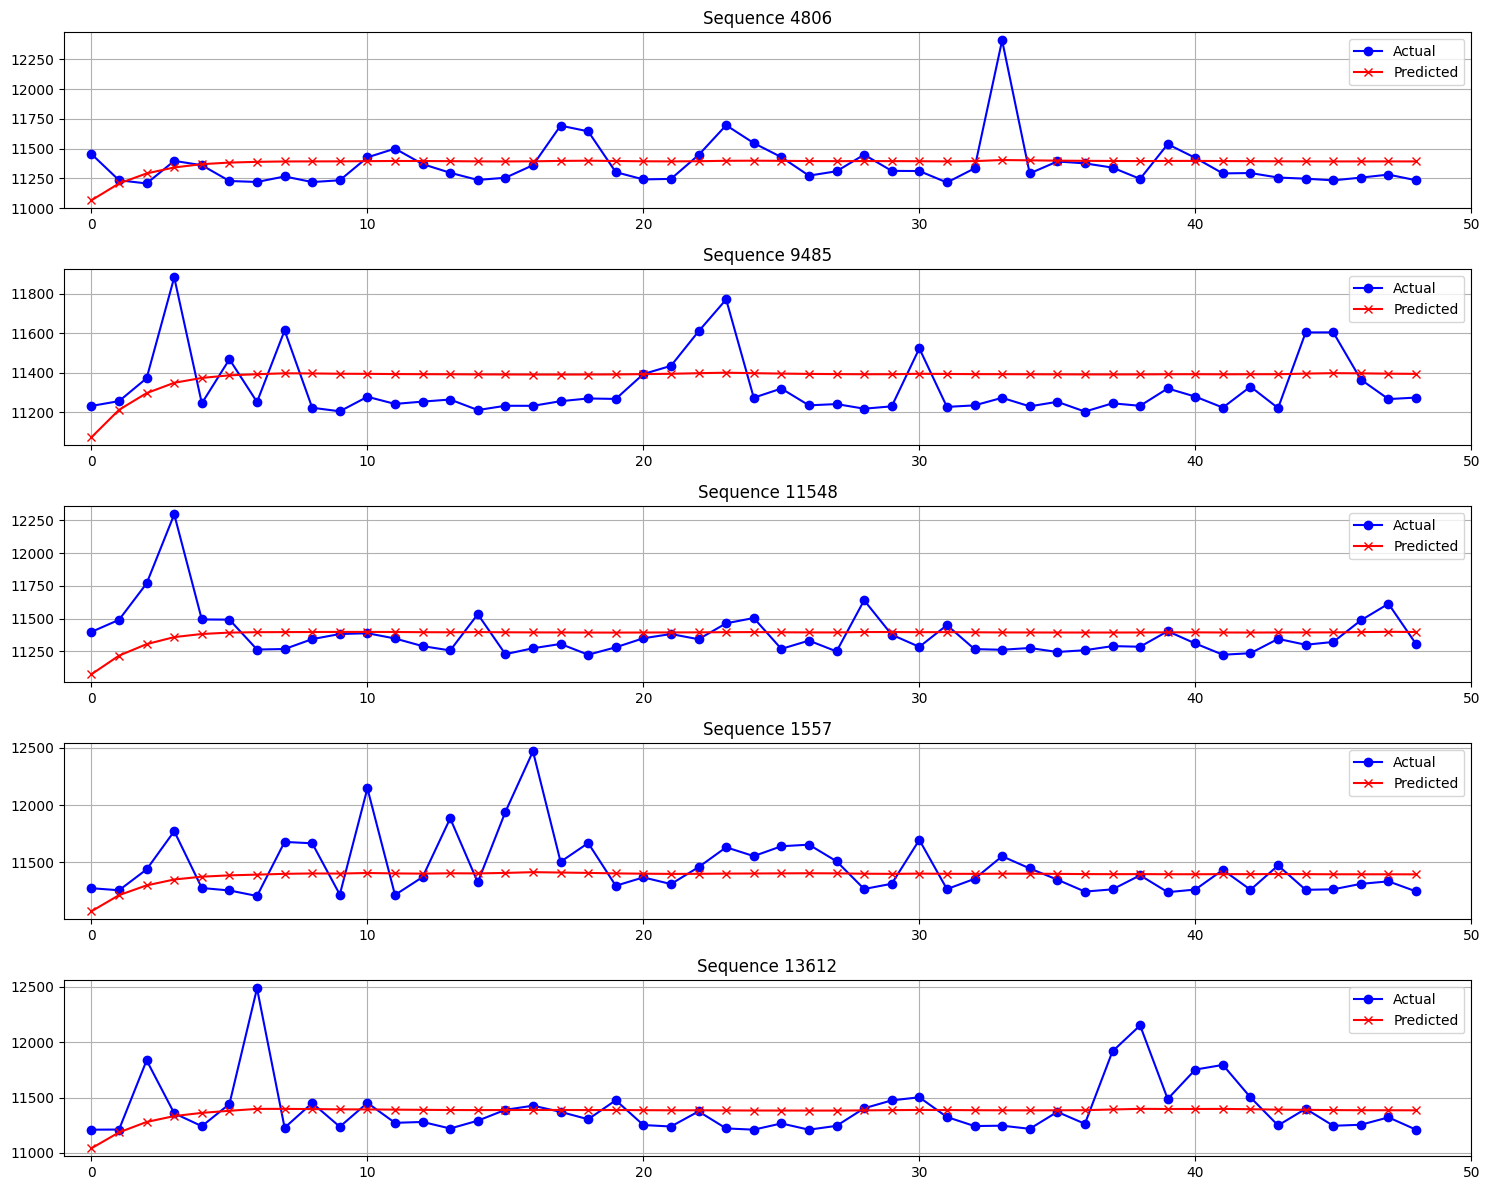

KeyboardInterrupt: 

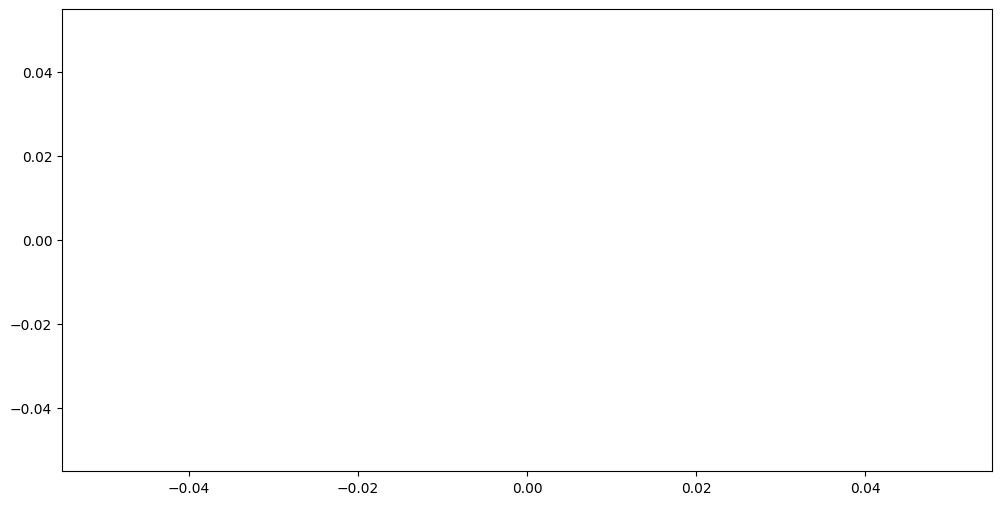

In [42]:
print(f"Final Test MSE: {mse:.4e}, MAE: {mae:.4e}")
print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
# Plot 5 random sequences
import matplotlib.pyplot as plt
import seaborn as sns
n_examples = 5
indices = np.random.choice(len(y_true), n_examples, replace=False)

# Create a figure with n_examples subplots stacked vertically
fig, axes = plt.subplots(n_examples, 1, figsize=(15, 12))
for idx, ax in zip(indices, axes):
    # Skip first value and take all remaining values
    true_seq = y_true[idx, 1:, 0]  # Start from index 1 instead of 0
    pred_seq = y_pred[idx, 1:, 0]  # Start from index 1 instead of 0
    
    # Create x-axis values for better visualization
    x_values = np.arange(len(true_seq))
    
    # Plot actual values in blue with circle markers
    ax.plot(x_values, true_seq, label='Actual', marker='o', color='blue')
    # Plot predicted values in red with x markers
    ax.plot(x_values, pred_seq, label='Predicted', marker='x', color='red')
    
    ax.set_title(f'Sequence {idx}')
    ax.legend()
    ax.grid(True)
    # Optionally set x-axis limits to extend beyond the data
    ax.set_xlim(-1, len(true_seq) + 1)  # Extend by 1 on each side

plt.tight_layout()
plt.show()

errors = (y_pred - y_true).reshape(-1)
plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [39]:
forecast_horizon = 30
# Example best

best = {'filters': 16, 'kernel_size': 2, 'lstm_units': 16, 'learning_rate': 0.0001, 'epochs': 1, 'window_size': 50, 'batch_size': 16}
mse, mae, y_pred, y_true, history = cnn_lstm_model_eval(df = data_frame,
                                               npy_path = npy_path,
                                               data_scaler = scaler,
                                               feat_idx = feat_idx,
                                               targ_idx = targ_idx,
                                               filters = best['filters'],
                                               window_size = best['window_size'],
                                               kernel_size = best['kernel_size'],
                                               lstm_units = best['lstm_units'],
                                               learning_rate = best['learning_rate'],
                                               epochs = best['epochs'],
                                               forecast_horizon = forecast_horizon,
                                               batch_size = best['batch_size'],
                                               num_workers = 4)

Starting training...
Epoch 01/1 — train_loss: 8.1472e-03 — time: 9.99s
Training complete in 10.00s
Starting evaluation on test set...
Test inference complete in 3.34s


Final Test MSE: 1.1581e+05, MAE: 1.9786e+02
y_true shape: (14321, 50, 30), y_pred shape: (14321, 50, 30)


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

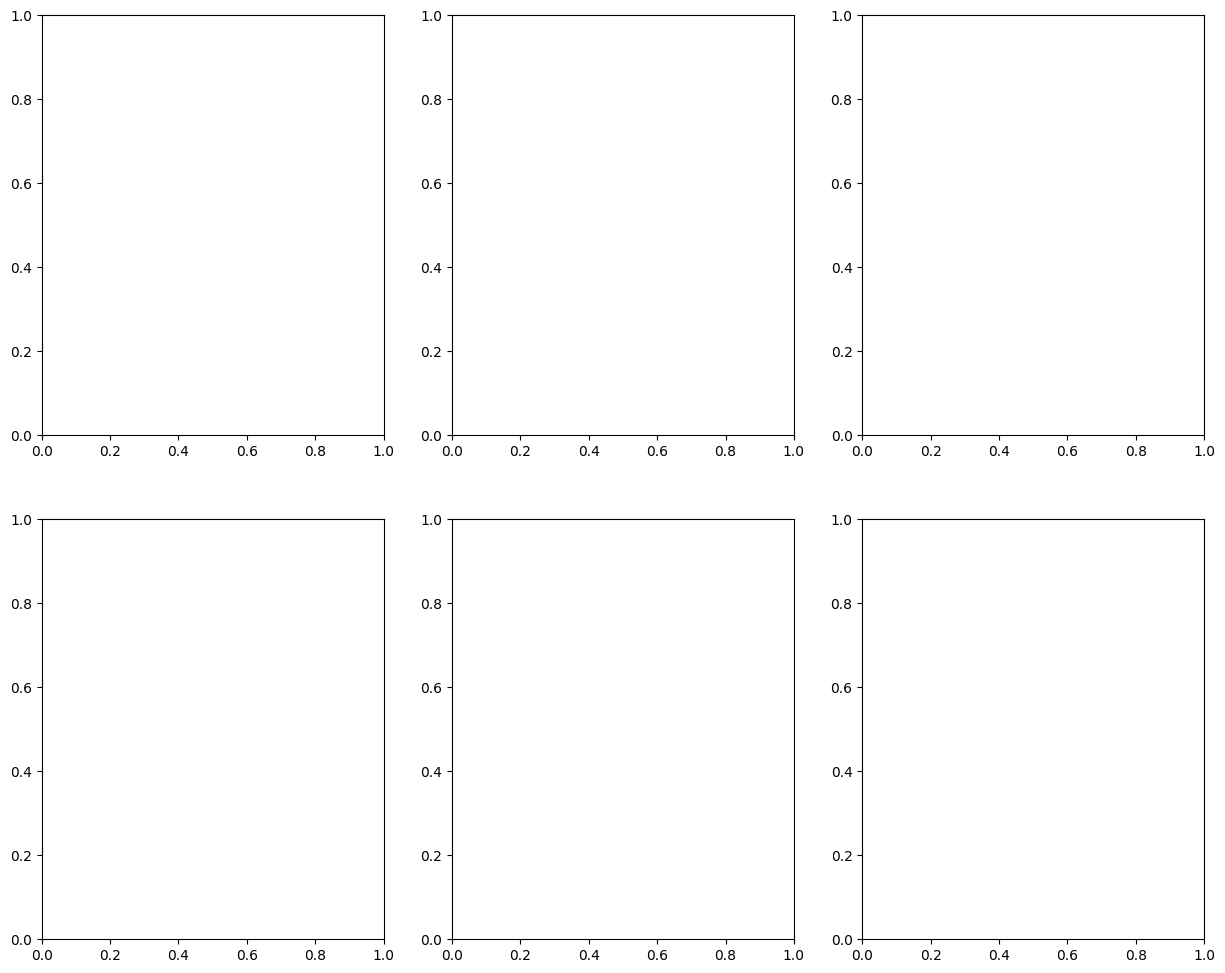

In [41]:
print(f"Final Test MSE: {mse:.4e}, MAE: {mae:.4e}")
print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")

# 1. Plot first 5 sequences showing actual vs predicted future values
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
indices = np.random.choice(len(y_true), 5, replace=False)

for i, (idx, ax) in enumerate(zip(indices, axes)):
    # Get the 5 future values for this sequence
    true_future = y_true[idx, 0, :]  
    pred_future = y_pred[idx, 0, :]  
    
    # Create x-axis for the 5 future timesteps
    x = np.arange(forecast_horizon)
    
    # Plot actual and predicted values
    ax.plot(x, true_future, 'bo-', label='Actual Future Values', marker='o')
    ax.plot(x, pred_future, 'ro--', label='Predicted Future Values', marker='x')
    
    ax.set_title(f'Sequence {idx}: Actual vs Predicted Future Values')
    ax.set_xlabel('Future Timestep')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
    ax.set_xticks(x)
    ax.set_xticklabels([f't+{i+1}' for i in range(5)])

plt.tight_layout()
plt.show()